<h1> 0. 모델 캐시 디렉토리 설정

In [ ]:
import torch
from transformers import pipeline, AutoModelForCausalLM, AutoTokenizer

# 모델과 토크나이저를 먼저 불러오면서 캐시 디렉터리 설정
model = AutoModelForCausalLM.from_pretrained(
    "google/gemma-2-9b-it", 
    torch_dtype=torch.bfloat16, 
    cache_dir="/workspace/youngwoo/KOBCLLM/cache"
)

tokenizer = AutoTokenizer.from_pretrained(
    "google/gemma-2-9b-it", 
    cache_dir="/workspace/youngwoo/KOBCLLM/cache"
)

# 파이프라인 설정
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    device="cuda",  # replace with "mps" to run on a Mac device
)

# 연결 테스트
messages = [
    {"role": "user", "content": "Who are you? Please, answer in pirate-speak."},
]

outputs = pipe(messages, max_new_tokens=256)
assistant_response = outputs[0]["generated_text"][-1]["content"].strip()
print(assistant_response)

<h1> 1. 데이터 전처리

In [ ]:
import pandas as pd

file_path = '/workspace/youngwoo/KOBCLLM/resource/신조선가/BULKER.xls' 
bulker_df = pd.read_excel(file_path, skiprows=1, engine='xlrd')
bulker_df = bulker_df.drop(columns=['번호'])
bulker_df = bulker_df.set_index('DATE')

print(bulker_df)

In [89]:
bulker_df.index = pd.to_datetime(bulker_df.index, format='%Y-%m-%d')

# 조건에 맞는 데이터 필터링 (괄호와 비트 연산자 사용)
filtered_bulker_df = bulker_df.loc[
    (bulker_df.index > '2022-06-01') & (bulker_df.index < '2024-06-30')
]

print(filtered_bulker_df)

            CAPE(180K)  KAMSARMAX(82K)  ULTRAMAX(64K)  HANDY(33K)
DATE                                                             
2024-06-27       72.66           37.63          34.86       31.53
2024-06-20       72.47           37.69          34.75       31.41
2024-06-13       71.70           37.74          34.58       31.52
2024-06-06       70.71           37.64          34.54       31.51
2024-05-30       69.92           37.69          34.28       31.37
...                ...             ...            ...         ...
2022-06-30       62.89           36.30          34.02       29.83
2022-06-23       62.74           36.21          33.97       29.74
2022-06-16       62.52           36.13          33.94       29.62
2022-06-09       62.39           36.00          33.89       29.60
2022-06-02       62.43           35.97          33.89       29.57

[109 rows x 4 columns]


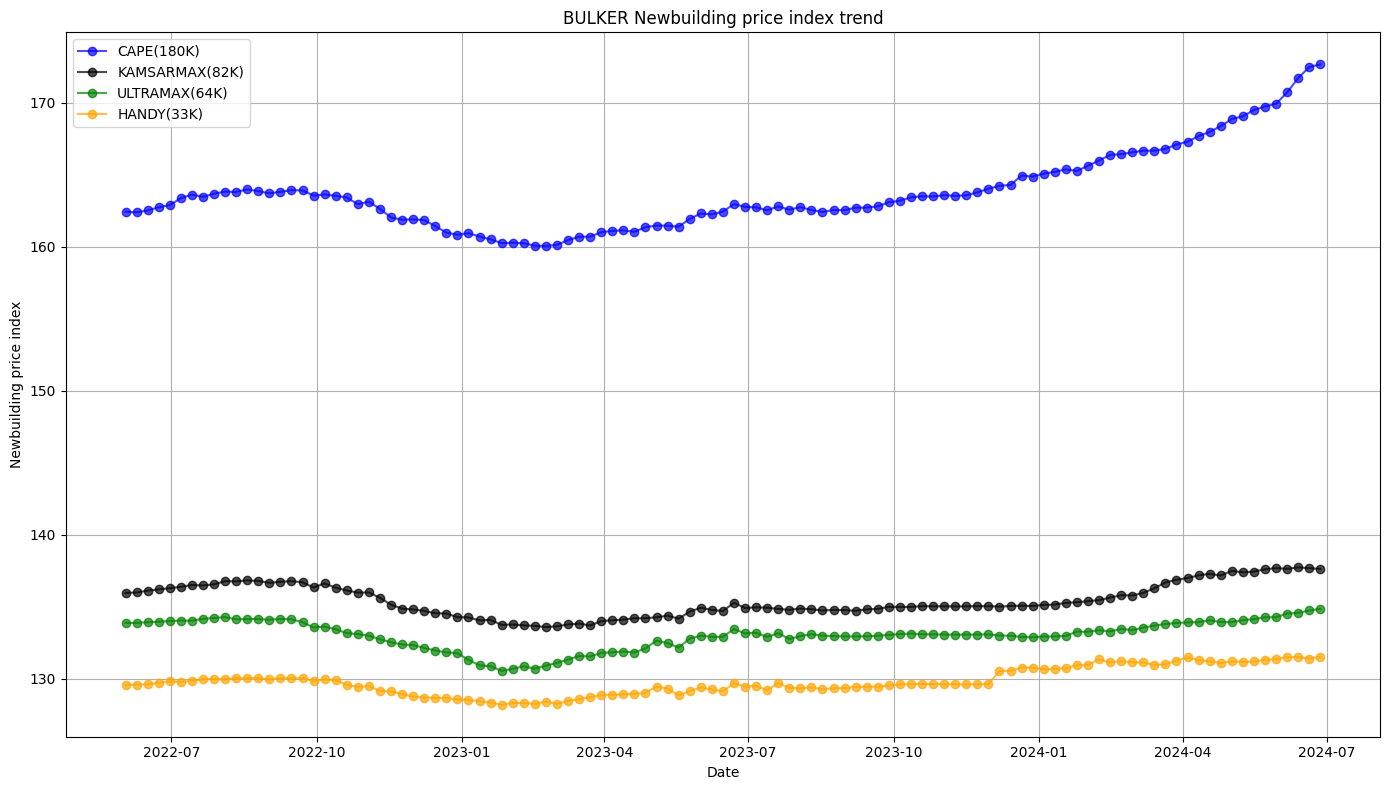

In [90]:
import pandas as pd
import matplotlib.pyplot as plt

filtered_bulker_df = filtered_bulker_df + 100

# 색상 매핑 정의 (원하는 대로 색상을 지정하세요)
color_mapping = {
    # 'VLCC(320K)': 'red',
    # 'SUEZMAX(160K)': 'blue',
    # 'AFRAMAX(110K)': 'green',
    # 'LR2(110K)': 'orange',
    # 'LR1(74K)': 'purple',
    # 'MR(50K)': 'cyan',
    'CAPE(180K)': 'blue',
    'KAMSARMAX(82K)': 'black',
    'ULTRAMAX(64K)': 'green',
    'HANDY(33K)': 'orange'
}

plt.figure(figsize=(14, 8))

# 각 열에 대해 지정된 색상으로 그래프 그리기
for column in filtered_bulker_df.columns:
    plt.plot(
        filtered_bulker_df.index, 
        filtered_bulker_df[column],
        marker='o', 
        linestyle='-', 
        label=column,
        color=color_mapping.get(column, 'black'),  # 매핑에 없는 열은 'black'으로 설정
        alpha=0.7
    )

plt.title('BULKER Newbuilding price index trend')
plt.xlabel('Date')
plt.ylabel('Newbuilding price index')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [83]:
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage


DATAFRAME = filtered_bulker_df.to_html(index=True)
COLUMNS = filtered_bulker_df.columns.to_list()
MESSAGE = "벌크선의 신조선가 분석 후 동향을 말해주세요."

# 와,, f-string 왜 안했던거지,,
input_text = f"""당신은 데이터 분석 전문가입니다.

아래의 데이터 프레임은 사용자의 요청에 따라 데이터베이스에서 추출한 데이터프레임입니다.
{DATAFRAME}

해당 데이터 프레임은 신조선가 지수(newbuilding price index)는 88년 1월의 선가를 100으로 산출한 지수이며, 88년 1월보다 얼마나 상승했는지를 나타냅니다.
신조선가 지수 단위는 pt입니다.

사용자 요청에 대해 해당 데이터를 활용해 답변하세요.
추출된 각 연도, 연초, 연말, 분기와 같이 파트를 나눠 구체적인 %, pt 수치를 언급하며 비교하세요.
신조선가 지수 변동 이유, 근거는 구체적으로 말하세요.

# 사용자 요청
{MESSAGE}

아래는 답변 예시입니다.
ㅇ 6월 신조선가 지수 187.23pt로 전년동월비 9.5% 상승
- 연초대비 약 5% 상승했으며, ’08년 최고치 대비 2% 가량 낮은 수준, 제한적인 공급과 늘어난 수요로 상승 추세 지속 전망
ㅇ 6월 중고선가 지수 179.92pt로 전년동월비 18.3% 상승, ’22~’23년 보합세 후 ‘24년 1월부터 반등
- 운임 및 신조선가 상승 등의 효과로 유조선과 건화물선, 컨테이너선 전 선형에 걸쳐 상승하며 지수상승 견인

"""

In [91]:
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage


DATAFRAME = filtered_bulker_df.to_html(index=True)
COLUMNS = filtered_bulker_df.columns.to_list()
MESSAGE = "벌크선의 신조선가 분석 후 동향을 말해주세요."

# 와,, f-string 왜 안했던거지,,
input_text = f"""당신은 데이터 분석 전문가입니다.

아래의 데이터 프레임은 사용자의 요청에 따라 데이터베이스에서 추출한 데이터프레임입니다.
{DATAFRAME}

사용자 요청에 대해 해당 데이터를 활용해 답변하세요.

# 사용자 요청
{MESSAGE}

**참고사항:**
- 신조선가 지수(newbuilding price index)는 88년 1월의 선가를 100으로 산출한 지수이며, 88년 1월보다 얼마나 상승했는지를 나타냅니다.
- 신조선가 지수 단위는 pt입니다.
- 숫자 계산 시 소수점 두 자리까지 표기하세요.
- 분석 내용은 객관적이고 명확하게 작성하세요.
- 동일 연도, 월을 구체적인 %, pt 수치를 언급하며 비교하세요.
- 제한적인 공급과 증가된 수요 등 상승 추세의 원인을 분석하고, 향후 전망을 제시해 주세요.
- 필요 시 추가적인 배경 정보나 관련 트렌드를 포함해주세요.
"""

In [92]:
print(messages[0])

{'role': 'user', 'content': '당신은 데이터 분석 전문가입니다.\n\n아래의 데이터 프레임은 사용자의 요청에 따라 데이터베이스에서 추출한 데이터프레임입니다.\n<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th></th>\n      <th>CAPE(180K)</th>\n      <th>KAMSARMAX(82K)</th>\n      <th>ULTRAMAX(64K)</th>\n      <th>HANDY(33K)</th>\n    </tr>\n    <tr>\n      <th>DATE</th>\n      <th></th>\n      <th></th>\n      <th></th>\n      <th></th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <th>2024-06-27</th>\n      <td>272.66</td>\n      <td>237.63</td>\n      <td>234.86</td>\n      <td>231.53</td>\n    </tr>\n    <tr>\n      <th>2024-06-20</th>\n      <td>272.47</td>\n      <td>237.69</td>\n      <td>234.75</td>\n      <td>231.41</td>\n    </tr>\n    <tr>\n      <th>2024-06-13</th>\n      <td>271.70</td>\n      <td>237.74</td>\n      <td>234.58</td>\n      <td>231.52</td>\n    </tr>\n    <tr>\n      <th>2024-06-06</th>\n      <td>270.71</td>\n      <td>237.64</td>\n      <td>234.54</td>\n      <td>2

In [93]:
messages = [
    {"role": "user", "content":input_text},
]

# print(messages[0])

outputs = pipe(messages, max_new_tokens=1000)
assistant_response = outputs[0]["generated_text"][-1]["content"].strip()
print(assistant_response)

## 벌크선 신조선가 분석 및 동향

제공된 데이터를 바탕으로 벌크선 신조선가의 최근 동향을 분석해보겠습니다. 

**1. 최근 추세:**

* **상승 추세:** 2023년 1월부터 현재까지 벌크선 신조선가는 지속적인 상승세를 보이고 있습니다. 
* **구체적인 변화:** 2023년 1월 기준 신조선가는 160.25 pt였으며, 2023년 12월 기준으로는 164.87 pt까지 상승했습니다. 즉, 약 **2.87%** 상승한 것으로 나타납니다. 
* **월별 변동성:**  월별 변동성은 크게 다르지 않으며, 대체로 1~2 pt의 변동폭을 보입니다. 

**2. 상승 원인 분석:**

* **제한적인 공급:** 벌크선 건조는 일반적으로 장기간 소요되며, 최근 몇 년간 신규 주문이 감소하면서 공급이 부족해지고 있습니다. 
* **증가된 수요:** 글로벌 경제 회복과 해운 물류 수요 증가로 인해 벌크선 수요가 증가하고 있습니다. 특히, 탄소 배출 감축 목표 달성을 위한 친환경 선박 수요가 증가하고 있습니다.
* **원자재 가격 상승:** 벌크선 건조에 필요한 철강, 스틸 등 원자재 가격 상승이 신조선가 상승에 영향을 미치고 있습니다.

**3. 향후 전망:**

* **지속적인 상승 가능성:**  제한적인 공급과 증가된 수요가 지속될 경우, 벌크선 신조선가는 향후에도 상승할 가능성이 높습니다. 
* **불확실성:**  글로벌 경제 불확실성, 해운 시장 변동, 원자재 가격 변동 등 다양한 요인에 따라 신조선가는 변동될 수 있습니다.


**4. 추가 고려 사항:**

* **환율 변동:**  달러화 기준으로 계산되는 신조선가는 환율 변동에 영향을 받을 수 있습니다.
* **기술 발전:**  자율 운항 기술, 에너지 효율 개선 기술 등의 발전은 신조선가에 영향을 미칠 수 있습니다.


In [54]:
a =[ [72.66,72.47,71.70,70.71],
[37.63,37.69,37.74,37.64],
[34.86,34.75,34.58,34.54],
[31.53,31.41,31.52,31.51]]


tt = 0
for aa in a :
    t = sum(aa) / len(aa)
    tt += t
    # print(f"{t:.2f}")

print(f"{tt:.2f}")

175.73


In [55]:
import pandas as pd

# 데이터 입력
data = {
    'Date': ['2024-06-27'],
    'VLCC(320K)': [126.30],
    'SUEZMAX(160K)': [84.61],
    'AFRAMAX(110K)': [72.02],
    'LR2(110K)': [73.55],
    'LR1(74K)': [59.30],
    'MR(50K)': [48.67],
    'CAPE(180K)': [72.66],
    'KAMSARMAX(82K)': [37.63],
    'ULTRAMAX(64K)': [34.86],
    'HANDY(33K)': [31.53]
}

# 데이터프레임 생성
df = pd.DataFrame(data)

# 선박 유형별 DWT 설정
dwt = {
    'VLCC(320K)': 320000,
    'SUEZMAX(160K)': 160000,
    'AFRAMAX(110K)': 110000,
    'LR2(110K)': 110000,
    'LR1(74K)': 74000,
    'MR(50K)': 50000,
    'CAPE(180K)': 180000,
    'KAMSARMAX(82K)': 82000,
    'ULTRAMAX(64K)': 64000,
    'HANDY(33K)': 33000
}

# 각 선박 유형의 DWT당 건조 비용 계산 (USD/DWT)
for column in df.columns[1:]:
    dwt_value = dwt[column]
    df[f'{column}_per_DWT'] = df[column] / dwt_value * 1e6  # USD/DWT

# 평균 DWT당 건조 비용 계산
df['Average_per_DWT'] = df[[f'{col}_per_DWT' for col in dwt.keys()]].mean(axis=1)

# 기준 평균 DWT당 건조 비용 (예: 1988년 1월 기준)
base_average = 500  # USD/DWT

# 클락슨 신조선가 지수 계산
df['CNI'] = (df['Average_per_DWT'] / base_average) * 100

# 결과 출력
print(df[['Date', 'Average_per_DWT', 'CNI']])

         Date  Average_per_DWT         CNI
0  2024-06-27       638.432614  127.686523
